## Реализация StyleGAN-NADA

### Загрузка данных

Клонируем эталонную реализацию StyleGAN2, устанавливаем CLIP и другие зависимости

In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch stylegan

In [ ]:
%pip install git+https://github.com/openai/CLIP.git

In [ ]:
%pip install ftfy regex tqdm matplotlib

Скачиваем предобученные модели

In [ ]:
!wget -P /stylegan/pretrained https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
# !wget -P /stylegan/pretrained https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl
# !wget -P /stylegan/pretrained https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqcat.pkl
# !wget -P /stylegan/pretrained https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqdog.pkl

### Импорты и подготовка окружения

In [5]:
import pickle
import sys
import os
import gc
from typing import Iterable

import clip
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as tff
import torchvision.utils as tvutils
import matplotlib.pyplot as plt
from torchvision.transforms import (
    InterpolationMode,
    ToPILImage,
    Compose,
    Resize,
    CenterCrop,
    Normalize,
)
from tqdm.notebook import tqdm

### Проверка конфигурации устройства

In [6]:
!nvidia-smi

Tue Feb  4 03:26:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.78                 Driver Version: 550.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:01:00.0 Off |                  Off |
|  0%   30C    P8             34W /  475W |       4MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='cuda')

### Загрузка моделей

In [8]:
CLIP_MODEL = "ViT-B/32"
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [9]:
clip_model, clip_preprocess = clip.load(CLIP_MODEL, device=device, jit=True)
clip_model.eval();

100%|███████████████████████████████████████| 338M/338M [00:17<00:00, 20.3MiB/s]


In [10]:
os.environ["TORCH_CUDA_ARCH_LIST"] = "8.9"  # for RTX 40** series
if "/stylegan" not in sys.path:
    sys.path.extend(["/stylegan", "stylegan"])

In [ ]:
# with open("/stylegan/pretrained/afhqdog.pkl", "rb") as f:
# with open("/stylegan/pretrained/afhqcat.pkl", "rb") as f:
# with open("/stylegan/pretrained/metfaces.pkl", "rb") as f:
with open("/stylegan/pretrained/ffhq.pkl", "rb") as f:
    stylegan = pickle.load(f)

frozen_generator = stylegan["G_ema"].to(device)
frozen_generator.eval()
trained_generator = stylegan["G"].to(device)
trained_generator.train()
for param in trained_generator.parameters():
    param.requires_grad = True

print(f"{frozen_generator.training=}, {trained_generator.training=}")

frozen_generator.training=False, trained_generator.training=True


### Подготовка вспомогательного кода

In [12]:
to_pil = ToPILImage()

Словарь соответствия индексов латента $\mathcal{W}^+$ и слоёв генератора. Каждый индекс задевает и другие слои, но все они должны быть отключены.

In [13]:
INDEX_TO_LAYERS = {
    0: "b4.conv1",
    1: "b8.conv0",
    2: "b8.conv1",
    3: "b16.conv0",
    4: "b16.conv1",
    5: "b32.conv0",
    6: "b32.conv1",
    7: "b64.conv0",
    8: "b64.conv1",
    9: "b128.conv0",
    10: "b128.conv1",
    11: "b256.conv0",
    12: "b256.conv1",
    13: "b512.conv0",
    14: "b512.conv1",
    15: "b1024.conv0",
    16: "b1024.conv1",
    17: None,
}

In [14]:
def clip_loss(image: torch.Tensor, text_embedding: torch.Tensor) -> torch.Tensor:
    image_embed = clip_model.encode_image(image).mean(0)
    return 1 - torch.cosine_similarity(image_embed, text_embedding, dim=-1)

In [15]:
SIZE = clip_preprocess.transforms[0].size
clip_transform = Compose(
    [
        Resize(SIZE, interpolation=InterpolationMode.BICUBIC),
        CenterCrop(SIZE),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ]
)

In [16]:
def preprocess_images(images: torch.Tensor) -> torch.Tensor:
    clip_images = []
    for image in images:
        clip_transformed_image = clip_transform(image)
        clip_images.append(clip_transformed_image)

    return torch.stack(clip_images).to(device)

In [17]:
def choose_active_layer_indices(
    text, batch_size: int = 16, num_epochs: int = 16, num_indices: int = 4
) -> list[int]:
    z = torch.randn(batch_size, frozen_generator.z_dim, device=device)
    with torch.no_grad():
        latent = frozen_generator.mapping(z, None)

    initial_latent = latent.detach().clone()
    latent.requires_grad = True

    with torch.no_grad():
        tokenized_text = clip.tokenize(text).to(device)
        text_embedding = clip_model.encode_text(tokenized_text)

    optimizer = torch.optim.Adam([latent], lr=0.08)
    for _ in tqdm(range(num_epochs), desc="Choosing layers to freeze"):
        generated_images = frozen_generator.synthesis(latent, noise_mode="const")
        clip_preprocessed_images = preprocess_images(generated_images)

        img_clip_loss = clip_loss(clip_preprocessed_images, text_embedding)
        img_clip_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Выбираем латенты W+, которые изменились больше всего, и берём их индексы
    latent_delta = (latent - initial_latent).abs().mean(dim=(0, 2))
    sorted_indices = torch.argsort(latent_delta, descending=True)
    layer_indices = sorted_indices[:num_indices].tolist()

    return layer_indices

In [18]:
def set_trainable_layers(generator: nn.Module, active_layer_indices: Iterable[int]):
    layers_to_train = []
    for idx in active_layer_indices:
        if layer_name := INDEX_TO_LAYERS.get(idx):
            layers_to_train.append(f"synthesis.{layer_name}")

    for param_name, param in generator.named_parameters():
        param.requires_grad = False
        for layer_name in layers_to_train:
            if param_name.startswith(layer_name) and "affine" not in param_name:
                param.requires_grad = True
                break

    print("Generator active layers by block:")
    for name, block in trained_generator.synthesis.named_children():
        if any(param.requires_grad for param in block.parameters()):
            layers = list(
                block_layer_name
                for block_layer_name, block_layer in block.named_children()
                if any(param.requires_grad for param in block_layer.parameters())
            )
            print(f"{name:>5}:", *layers)

### Промпты

In [80]:
SOURCE_TEXT = "photo"
# SOURCE_TEXT = "cat"
# SOURCE_TEXT = "dog"
# SOURCE_TEXT = "painting"

# TARGET_TEXT = "sunglasses"
# TARGET_TEXT = "oil painting"
TARGET_TEXT = "impressionist portrait"
# TARGET_TEXT = "beard and mustache"
# TARGET_TEXT = "rembrandt"
# TARGET_TEXT = "anime"
# TARGET_TEXT = "cubism"

MODEL_PATH = f"/workspace/{SOURCE_TEXT.replace(' ', '_')}_{TARGET_TEXT.replace(' ', '_')}_trained_generator.pt"

In [20]:
def freeze_layers(generator: nn.Module, num_indices: int = 5):
    active_layer_indices = choose_active_layer_indices(TARGET_TEXT, num_indices=num_indices)
    set_trainable_layers(generator, active_layer_indices)

In [21]:
def get_image_clip_embeddings(images: torch.Tensor) -> torch.Tensor:
    images = (images + 1) * 0.5
    images = torch.clamp(images, 0, 1)
    preprocessed_images = preprocess_images(images)
    image_clip_embeddings = clip_model.encode_image(preprocessed_images)

    return image_clip_embeddings

In [22]:
def compute_directional_loss(trained_images, frozen_images, text_delta, alpha=1.0):
    train_embeddings = get_image_clip_embeddings(trained_images)
    frozen_embeddings = get_image_clip_embeddings(frozen_images)
    image_delta = (train_embeddings - frozen_embeddings).mean(dim=0).unsqueeze(0)

    cos_sim = F.cosine_similarity(image_delta, text_delta).mean(dim=0)
    directional_loss = alpha * (1 - cos_sim)

    return directional_loss

In [24]:
def train_nada(
    trained_generator: nn.Module,
    frozen_generator: nn.Module,
    source_text: str,
    target_text: str,
    num_epochs: int = 100,
    batch_size: int = 2,
    scheduler_step: int = 100,
    scheduler_gamma: float = 0.75,
    lr: float = 0.002,
    num_layers_to_freeze: int = 5,
    loss_min: float = float("inf"),
):
    gc.collect()
    torch.cuda.empty_cache()
    trained_generator.train()
    frozen_generator.eval()
    with torch.no_grad():
        target_token = clip.tokenize(target_text).to(device)
        source_token = clip.tokenize(source_text).to(device)
        target_embedding = clip_model.encode_text(target_token)
        source_embedding = clip_model.encode_text(source_token)

    text_delta = target_embedding - source_embedding

    freeze_layers(trained_generator, num_indices=num_layers_to_freeze)
    trainable_params = (param for param in trained_generator.parameters() if param.requires_grad)
    optimizer = torch.optim.Adam(trainable_params, lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=scheduler_step, gamma=scheduler_gamma
    )
    for epoch in tqdm(range(num_epochs)):
        z = torch.randn(batch_size, trained_generator.z_dim, device=device)
        ws = trained_generator.mapping(z, None)

        trained_images = trained_generator.synthesis(ws, noise_mode="const")
        with torch.no_grad():
            frozen_images = frozen_generator.synthesis(ws, noise_mode="const")

        loss = compute_directional_loss(trained_images, frozen_images, text_delta)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

        if loss < loss_min:
            loss_min = loss
            torch.save(
                {"generator_state_dict": trained_generator.state_dict(), "loss_min": loss_min},
                MODEL_PATH,
            )
            print(f"New loss minimum: {loss_min.item():.4f}, checkpoint saved in {MODEL_PATH}")

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs}   Loss: {loss.item():.4f}")
            with torch.no_grad():
                images = torch.cat([frozen_images[:3], trained_images[:3]], dim=0)
                fake_img_grid = tvutils.make_grid(images, nrow=3, padding=8, normalize=True)
                plt.imshow(fake_img_grid.permute(1, 2, 0).cpu())
                plt.axis("off")
                plt.show()

        del z, ws, trained_images, frozen_images

    return loss_min

In [81]:
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
trained_generator.load_state_dict(checkpoint["generator_state_dict"])
loss_min = checkpoint["loss_min"]

### Обучение

Setting up PyTorch plugin "bias_act_plugin"... Done.


Choosing layers to freeze:   0%|          | 0/16 [00:00<?, ?it/s]

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generator active layers by block:
  b32: conv0 conv1
  b64: conv0
 b128: conv0
 b256: conv0 conv1
 b512: conv1
b1024: conv0 conv1


  0%|          | 0/51 [00:00<?, ?it/s]

New loss minimum: 0.3433, checkpoint saved in /workspace/painting_sunglasses_trained_generator2.pt
Epoch 0/51   Loss: 0.3433


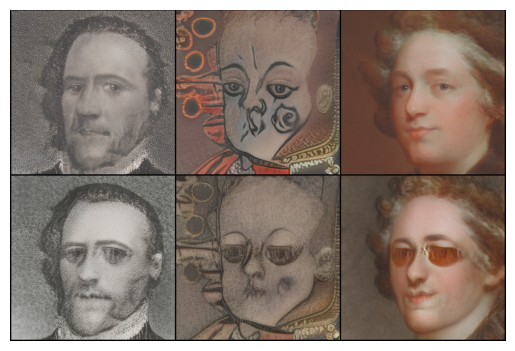

New loss minimum: 0.3364, checkpoint saved in /workspace/painting_sunglasses_trained_generator2.pt
Epoch 10/51   Loss: 0.3481


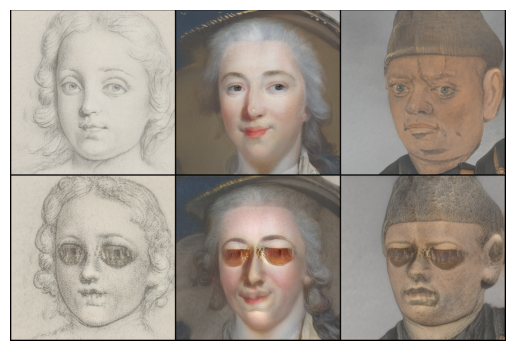

Epoch 20/51   Loss: 0.3687


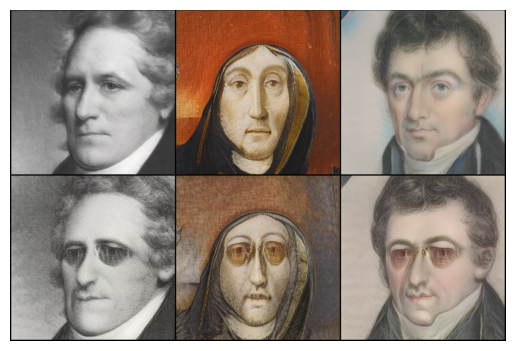

Epoch 30/51   Loss: 0.3462


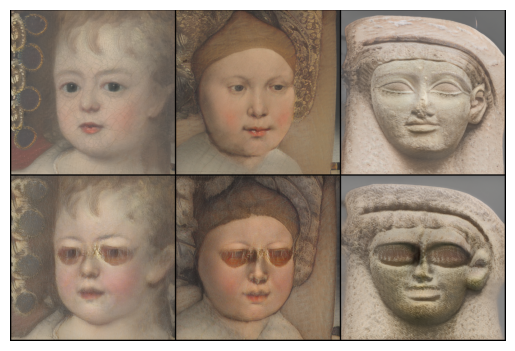

New loss minimum: 0.3271, checkpoint saved in /workspace/painting_sunglasses_trained_generator2.pt
Epoch 40/51   Loss: 0.3516


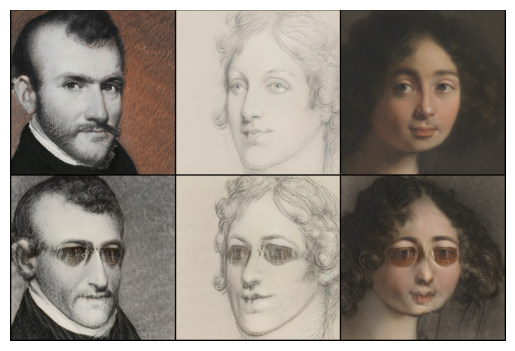

Epoch 50/51   Loss: 0.3413


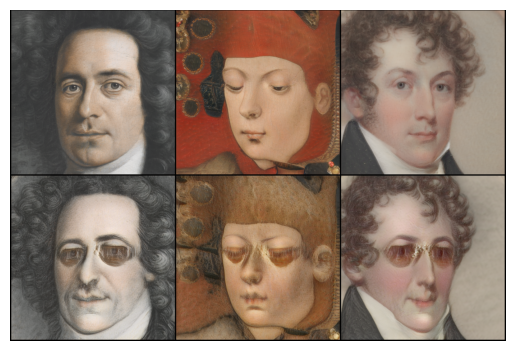

In [82]:
loss_min = train_nada(
    trained_generator,
    frozen_generator,
    SOURCE_TEXT,
    TARGET_TEXT,
    num_epochs=51,
    batch_size=16,
    # scheduler_step=40,
    # scheduler_gamma=0.5,
    lr=0.001,
    num_layers_to_freeze=9,  # заморозим половину слоёв, обычно это даёт неплохой результат
    # loss_min=loss_min,
)

### Очистка памяти

In [108]:
torch.cuda.empty_cache()
gc.collect()

3876

### Генерация изображений

In [27]:
def generate_images(generator: nn.Module, num_images: int = 8):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_images, generator.z_dim, device=device)
        ws = generator.mapping(z, None)
        images = generator.synthesis(ws, noise_mode="const")
        images = (images + 1) * 0.5
        images = torch.clamp(images, 0, 1)

    return images

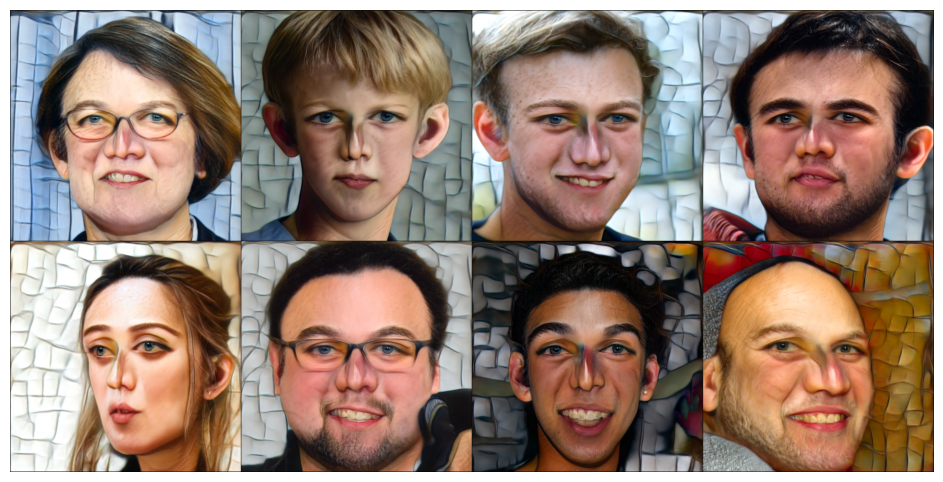

In [82]:
images = generate_images(trained_generator, num_images=8)
image_grid = tvutils.make_grid(images, nrow=4, padding=2)
plt.figure(figsize=(12, 6))
plt.imshow(image_grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.show()

### Редактирование

In [30]:
# !git clone https://github.com/omertov/encoder4editing.git

In [31]:
# %pip install dlib scipy

In [32]:
# !wget -O /workspace/e4e_ffhq_encode.pt https://www.dropbox.com/scl/fi/ot6yskqtzepokg5x5gw55/e4e_ffhq_encode.pt?rlkey=64q1tx0gxaasiyzc11tzcdj8q&e=1&dl=1

In [33]:
# !wget -O /workspace/input_img.jpg https://www.dropbox.com/scl/fi/4i9bgvhemfk1n2otj9z3e/input_img.jpg?rlkey=0cw9sqmkts5cqkwg8kr0ebt2z&dl=1

In [29]:
if "/encoder4editing" not in sys.path:
    sys.path.append("/encoder4editing")
sys.path

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/venv/main/lib/python3.10/site-packages',
 '/tmp/tmpj7ci64rt',
 '/stylegan',
 'stylegan',
 '/encoder4editing']

In [30]:
from argparse import Namespace

import dlib
import torchvision.transforms as transforms
from encoder4editing.models.psp import pSp
from encoder4editing.utils.alignment import align_face
from PIL import Image

In [ ]:
resize_dims = (256, 256)
model_path = "/workspace/e4e_ffhq_encode.pt"
checkpoint = torch.load(model_path, weights_only=False)
opts = checkpoint["opts"]
opts["checkpoint_path"] = model_path
opts = Namespace(**opts)
opts.output_size = 1024
encoder = pSp(opts).to(device)
encoder.eval()
print("Model successfully loaded!")

In [32]:
if "shape_predictor_68_face_landmarks.dat" not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

Aligned image has shape: (256, 256)


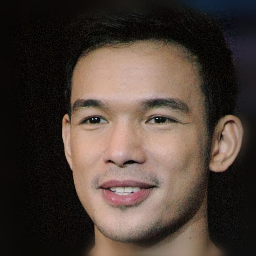

In [33]:
def run_alignment(image_path):
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor)
    print(f"Aligned image has shape: {aligned_image.size}")
    return aligned_image


input_image = run_alignment("/workspace/input_img.jpg")
input_image.resize((256, 256))

In [34]:
import numpy as np
from time import perf_counter
from utils.common import tensor2im


def display_alongside_source_image(result_image, source_image):
    res = np.concatenate(
        [np.array(source_image.resize(resize_dims)), np.array(result_image.resize(resize_dims))],
        axis=1,
    )
    return Image.fromarray(res)


def run_on_batch(inputs, net):
    return net(inputs.cuda().float(), randomize_noise=False, return_latents=True)

Inference took 0.1474 seconds.


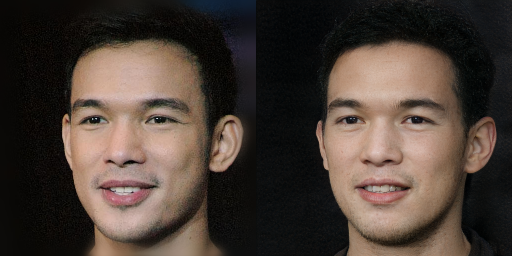

In [35]:
img_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)
transformed_image = img_transforms(input_image)
with torch.no_grad():
    tic = perf_counter()
    images, latents = run_on_batch(transformed_image.unsqueeze(0), encoder)
    result_image, latent = images[0], latents[0]
    toc = perf_counter()
    print("Inference took {:.4f} seconds.".format(toc - tic))

display_alongside_source_image(tensor2im(result_image), input_image)

In [36]:
%matplotlib inline

In [37]:
def plot_edited_image(latents, checkpoint_path, direct=False) -> np.array:
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    trained_generator.load_state_dict(checkpoint if direct else checkpoint["generator_state_dict"])
    with torch.no_grad():
        image = trained_generator.synthesis(latents, noise_mode="const")
    normilized_image = image[0].permute(1, 2, 0).add(1).div(2).mul(255).clamp(0, 255)
    normilized_image = normilized_image.byte().detach().cpu().numpy()
    return normilized_image

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


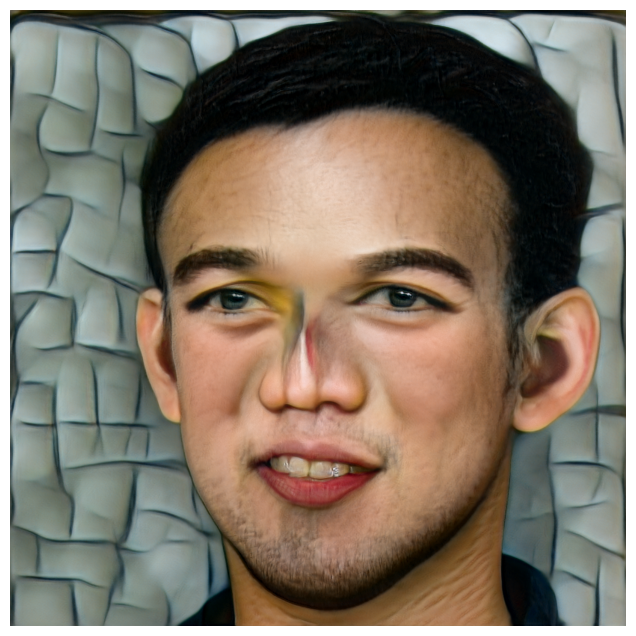

In [32]:
image_to_plot = plot_edited_image(latents, "/workspace/photo_cubism_trained_generator.pt")
plt.figure(figsize=(8, 8))
plt.imshow(image_to_plot)
plt.axis("off")
plt.show()

In [ ]:
image_to_plot = plot_edited_image(latents, "/workspace/photo_rembrandt_trained_generator.pt")
plt.figure(figsize=(8, 8))
plt.imshow(image_to_plot)
plt.axis("off")
plt.show()

In [ ]:
image_to_plot = plot_edited_image(latents, "/workspace/photo_oil_painting_trained_generator.pt")
plt.figure(figsize=(8, 8))
plt.imshow(image_to_plot)
plt.axis("off")
plt.show()

In [ ]:
image_to_plot = plot_edited_image(latents, "/workspace/photo_shrek_trained_generator.pt")
plt.figure(figsize=(8, 8))
plt.imshow(image_to_plot)
plt.axis("off")
plt.show()

In [ ]:
image_to_plot = plot_edited_image(
    latents, "/workspace/photo_impressionist_portrait_trained_generator.pt"
)
plt.figure(figsize=(8, 8))
plt.imshow(image_to_plot)
plt.axis("off")
plt.show()

In [ ]:
image_to_plot = plot_edited_image(latents, "/workspace/photo_pirate_trained_generator.pt")
plt.figure(figsize=(8, 8))
plt.imshow(image_to_plot)
plt.axis("off")
plt.show()

In [ ]:
image_to_plot = plot_edited_image(
    latents, "/workspace/photo_beard_and_mustache_trained_generator.pt"
)
plt.figure(figsize=(8, 8))
plt.imshow(image_to_plot)
plt.axis("off")
plt.show()


In [ ]:
image_to_plot = plot_edited_image(latents, "/workspace/classicism_portrait_trained_generator2.pt")
plt.figure(figsize=(8, 8))
plt.imshow(image_to_plot)
plt.axis("off")
plt.show()

In [ ]:
image_to_plot = plot_edited_image(latents, "/workspace/photo_punk_style_trained_generator.pt")
plt.figure(figsize=(8, 8))
plt.imshow(image_to_plot)
plt.axis("off")
plt.show()

In [ ]:
image_to_plot = plot_edited_image(latents, "/workspace/photo_anime_trained_generator.pt")
plt.figure(figsize=(8, 8))
plt.imshow(image_to_plot)
plt.axis("off")
plt.show()

In [ ]:
image_to_plot = plot_edited_image(latents, "/workspace/photo_avantgarde_trained_generator.pt")
plt.figure(figsize=(8, 8))
plt.imshow(image_to_plot)
plt.axis("off")
plt.show()

In [ ]:
image_to_plot = plot_edited_image(
    latents, "/workspace/photo_classicism_portrait_trained_generator.pt"
)
plt.figure(figsize=(8, 8))
plt.imshow(image_to_plot)
plt.axis("off")
plt.show()

In [ ]:
image_to_plot = plot_edited_image(latents, "/workspace/painting_sunglasses_trained_generator.pt")
plt.figure(figsize=(8, 8))
plt.imshow(image_to_plot)
plt.axis("off")
plt.show()